In [15]:
import os
import json
import collections
import itertools
import copy
import pandas as pd
import seaborn as sns
from matplotlib import pyplot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import matplotlib
from scipy import stats
from scipy.misc import derivative

# Pval generation related functions, previously in the notebook
from booltest.pvals import *

In [2]:
def pvalue_comp(fnc, extremes, dx, bin_tup, by_bins=True):
    """Extremes = [(val, direction +1\-1)] """
    nints = len(extremes)
    areas = [0] * nints
    nbounds = [x[0] for x in extremes]
    nbins = [binize(x[0], bin_tup) for x in extremes]
    bmin = min(nbounds)
    bmax = max(nbounds)
    cp = 0
    iterc = 0
    results = []
    print('OK: ', nints, nbins, ' size: ', bin_tup[4])
    
    while cp <= 1.0:  # integration step
        iterc += 1
        if iterc > 10000:
            raise ValueError('exc')  # Hard-termination to avoid infinite cycle.
        
        # Integration by increasing pvalue and tabulating.
        # Each area grows at the same pace. pvalue is a sum of areas.
        # Termination - bounds are crossing / touching.
        
        # Integrate each area with one step but in such a way the area is the same. 
        max_area = max(areas)
        min_area = min(areas)
        sum_area = sum(areas)
        err = max([abs(x) for x in all_diffs(areas)])
        areas_str = ['%.7f' % x for x in areas]
        #print('Main iter: %s, cp: %.7f, mina: %.7f, maxa: %.7f, suma: %.7f, err: %.7f, a: [%s], n: %s' 
        #      % (iterc, cp, min_area, max_area, sum_area, err, ', '.join(areas_str), nbins))
        
        subit = 0
        while any([x <= min_area for x in areas]):
            subit += 1
            #print('.. subit: %s' % subit)
            
            for ix in range(nints):
                if areas[ix] > min_area :
                    continue
                if by_bins:
                    areas[ix] += get_bin_val(nbins[ix], bin_tup)
                    nbounds[ix] = get_bin_start(nbins[ix], bin_tup)
                    nbins[ix] = move_bound(nbins[ix], 1, extremes[ix][1])
                else:
                    areas[ix] += fnc(nbounds[ix])
                    nbounds[ix] = move_bound(nbounds[ix], dx, extremes[ix][1])        
        cp = sum(areas)
        
        crit_int = [None]*nints
        for i in range(nints):
            crit_int[i] = (extremes[i][0], nbounds[i]) if extremes[i][1] > 0 else (nbounds[i], extremes[i][0])
            
        results.append((cp, crit_int, copy.deepcopy(areas), err))
        
    #print('Main iter: %s, cp: %s, mina: %s, maxa: %s, suma: %s, a: %s' 
    #          % (iterc, cp, min(areas), max(areas), sum(areas), areas))
    #print('Total: %s' % (sum([get_bin_val(ix, bin_tup) for ix in range(len(bin_tup[0]))])))
    #print(json.dumps(results, indent=2))
    return results


def tabulate_pvals(val, nbins=200, abs_val=False, target_pvals=[0.0,0.0001,0.0005,0.001,0.005,0.01]):
    inp_iter = val['zscores']
    if abs_val:
        inp_iter = [abs(x) for x in inp_iter]
    
    bin_tup = get_bins(inp_iter, nbins=nbins, full=True)
    bb = get_distrib_fbins(inp_iter, bin_tup)
    
    bin_size = bin_tup[1]
    minv, maxv = bin_tup[2], bin_tup[3] 
    bins = np.array([x[0] for x in bb])
    
    # Tabulate pvalues
    # build_integrator(bin_tup)
    extremes = [
        [minv, 1],
        [0, -1],
        [0, +1],
        [maxv, -1]
    ] if not abs_val else [
        [minv, 1],
        [maxv, -1]
    ]
    
    print('%s-%s-%s-%s-%s' % (val['method'], val['block'], val['deg'], val['comb_deg'], val['data_size']))
    pvals = pvalue_comp(lambda x: binned_pmf(x, bin_tup), extremes, 
                        dx=1./(nbins/10.), bin_tup=bin_tup, by_bins=True)

    res_pdata = []
    for target in target_pvals:
        chosen = 0
        for i in range(len(pvals)):
            chosen = i
            if pvals[i][0] >= target:
                chosen = i - 1 if i > 0 else 0
                break
                
        cdata = pvals[chosen]
        res_pdata.append(collections.OrderedDict([
            ('pval_target', target),
            ('pval', cdata[0]),
            ('crit', cdata[1]),
            ('areas', cdata[2]),
            ('err', cdata[3]),
        ]))

    return collections.OrderedDict([
        ('method', val['method']), 
        ('block', val['block']),
        ('deg', val['deg']),
        ('comb_deg', val['comb_deg']),
        ('data_size', val['data_size']),
        ('nsamples', len(inp_iter)),
        ('nbins', nbins),
        ('abs_val', abs_val),
        ('binsize', bin_size),
        ('minv', minv),
        ('maxv', maxv),
        ('extremes', extremes),
        ('pvals', res_pdata)
    ])


In [3]:
#js = json.load(open('ref_1554219251.json'))
#csv = open('ref_1554219251.csv').read()
csv = open('ref_1558361146.csv').read()

csv_data = []
for rec in [x.strip() for x in csv.split("\n")]:
    p = rec.split(';')
    if len(p) < 6:
        continue
    cur = collections.OrderedDict([
        ('method', p[0]), 
        ('block', int(p[1])),
        ('deg', int(p[2])),
        ('comb_deg', int(p[3])),
        ('data_size', int(p[4])),
        ('zscores', [float(x.replace(',','.')) for x in p[6:]])
    ])
    csv_data.append(cur)
print(json.dumps(csv_data[0]))  

{"method": "in0-kctr-ri1", "block": 128, "deg": 1, "comb_deg": 2, "data_size": 10, "zscores": [-3.77991]}


In [4]:
data = csv_data
data_filt = [x for x in data if x and len(x['zscores']) > 1000]
data_filt.sort(key=lambda x: (x['method'], x['block'], x['deg'], x['comb_deg'], x['data_size']))
np.random.seed(87655677)

In [5]:
pval_db = []
for dix, val in enumerate(data_filt):
    res = tabulate_pvals(val, abs_val=True)
    pval_db.append(res)
    print('Dump %s' % dix)
json.dump(pval_db, open('pval_db.json', 'w+'), indent=2)

inctr-krnd-ri0-128-1-1-10
OK:  2 [0, 153]  size:  20000
Dump 0
inctr-krnd-ri0-128-1-2-10
OK:  2 [0, 146]  size:  19999
Dump 1
inctr-krnd-ri0-128-1-3-10
OK:  2 [0, 138]  size:  20000
Dump 2
inctr-krnd-ri0-128-2-1-10
OK:  2 [0, 149]  size:  20000
Dump 3
inctr-krnd-ri0-128-2-2-10
OK:  2 [0, 147]  size:  20000
Dump 4
inctr-krnd-ri0-128-2-3-10
OK:  2 [0, 143]  size:  20001
Dump 5
inctr-krnd-ri0-128-3-1-10
OK:  2 [0, 144]  size:  20000
Dump 6
inctr-krnd-ri0-128-3-2-10
OK:  2 [0, 139]  size:  20001
Dump 7
inctr-krnd-ri0-128-3-3-10
OK:  2 [0, 145]  size:  20001
Dump 8
inctr-krnd-ri0-256-1-1-10
OK:  2 [0, 148]  size:  20000
Dump 9
inctr-krnd-ri0-256-1-2-10
OK:  2 [0, 149]  size:  19999
Dump 10
inctr-krnd-ri0-256-1-3-10
OK:  2 [0, 149]  size:  20000
Dump 11
inctr-krnd-ri0-256-2-1-10
OK:  2 [0, 144]  size:  20001
Dump 12
inctr-krnd-ri0-256-2-2-10
OK:  2 [0, 142]  size:  20000
Dump 13
inctr-krnd-ri0-256-2-3-10
OK:  2 [0, 144]  size:  20000
Dump 14
inctr-krnd-ri0-256-3-1-10
OK:  2 [0, 141]  size:  

inctr-krnd-ri0[128:1:1:10]: 20000 
<class 'scipy.stats._distn_infrastructure.rv_discrete'>
[0. 0. 0.]
[5.0e-05 1.0e-04 1.5e-04]
OK:  2 [0, 153]  size:  20000
inctr-krnd-ri0[128:1:1:10]: 20000 [4.92043868 4.40457212 3.93169444 3.52330008 3.32985012 2.77099468
 0.760756   5.04940532 1.80374488 1.91121708 2.36260032 3.32985012]
Plotting area under:  (0.01445, [(1.760756, 2.06167816), (4.03916664, 5.059644)], [0.00785, 0.0066], 0.001899999999999999)


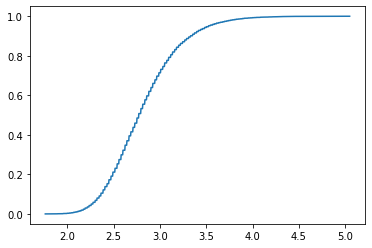

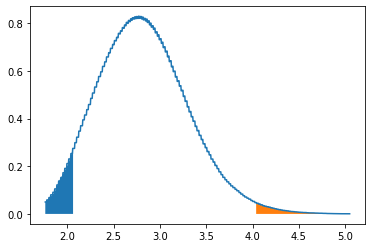

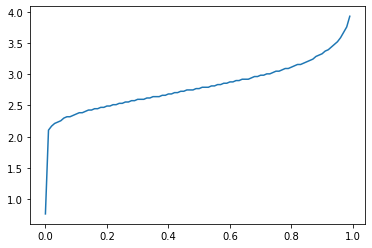

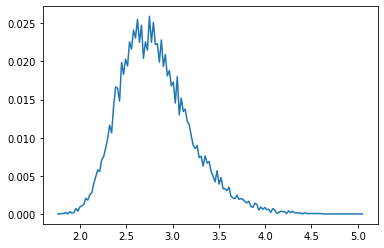

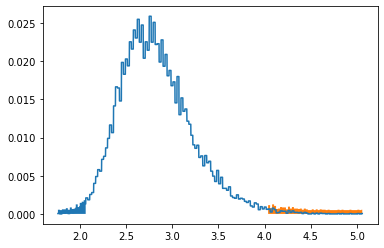

In [6]:
nbins = 200
abs_val = True
    
for dix, val in enumerate(data_filt):
    inp_iter = (val['zscores'])
    if abs_val:
        inp_iter = [abs(x) for x in inp_iter]
    
    print('%s[%s:%s:%s:%s]: %s %s' 
          % (val['method'], val['block'], val['deg'], val['comb_deg'], 
             val['data_size'], len(val['zscores']),
             '',#dst.ppf([1-0.0001, 1-0.001, 1-0.01, 1-0.05, 1-0.10, 1-0.5, 0, 1, 0.0001, 0.001, 0.1, 0.9])
             #dst.stats(moments='mvsk')
            ))
    
    bin_tup = get_bins(inp_iter, nbins=nbins, full=True)
    bb = get_distrib_fbins(inp_iter, bin_tup)
    
    bin_size = bin_tup[1]
    minv, maxv = bin_tup[2], bin_tup[3] 
    bins = np.array([x[0] for x in bb])
    dst = stats.rv_discrete(values=([x[0] for x in bb], [x[1] for x in bb]))
    print(stats.rv_discrete)
    
    x=np.array([bins[0], bins[1], bins[6]])
    print(dst.pmf(x))
    print(dst._pmf(x))
    
    # Tabulate pvalues
    build_integrator(bin_tup)
    extremes = [
        [minv, 1],
        [0, -1],
        [0, +1],
        [maxv, -1]
    ] if not abs_val else [
        [minv, 1],
        [maxv, -1]
    ]
    
    pvals = pvalue_comp(lambda x: binned_pmf(x, bin_tup), extremes, 
                        dx=1./(nbins/10.), bin_tup=bin_tup, by_bins=True)
    
    n_sample = 100
    rvs = dst.rvs(size=n_sample)
    f, l = np.histogram(rvs, bins=bins)
    f = np.append(f, [0])
    probs = np.array([x[1] for x in bb])
    #print(bins, len(bins))
    #print(probs, len(probs))
    #print(f, len(f))
    #sfreq = np.vstack([np.array([x[0] for x in bb]), f, probs*n_sample]).T
    #print(sfreq)
    
    print('%s[%s:%s:%s:%s]: %s %s' 
          % (val['method'], val['block'], val['deg'], val['comb_deg'], 
             val['data_size'], len(val['zscores']),
             dst.ppf([1-0.0001, 1-0.001, 1-0.01, 1-0.05, 1-0.10, 1-0.5, 0, 1, 0.0001, 0.001, 0.1, 0.9])
             #dst.stats(moments='mvsk')
            ))
    
    x = np.linspace(min(bins),max(bins),1000)
    plt.plot(x, dst.cdf(x))
    plt.show()
    
    cdf_dev = derivative(dst.cdf, x, dx=0.5)
    plt.plot(x,cdf_dev)
    
    sec_x = pvals[40]  # 49
    print('Plotting area under: ', sec_x)
    for ix in range(len(sec_x[1])):
        section = np.arange(sec_x[1][ix][0], sec_x[1][ix][1], 1/20.)
        plt.fill_between(section, derivative(dst.cdf, section, dx=0.5))
    plt.show()
    
    #for pv in pvals:
    #    sec_x = pv
    #    for ix in range(len(sec_x[1])):
    #        section = np.arange(sec_x[1][ix][0], sec_x[1][ix][1], 1/20.)
    #        plt.fill_between(section, derivative(dst.cdf, section, dx=0.5))
    #    plt.show()
    
    x = np.linspace(0,100,10000)
    plt.plot(x,dst.ppf(x))
    plt.show()
    
    x = np.linspace(minv,maxv,10000)
    plt.plot(bins, dst._pmf(bins))
    plt.show()
    
    x = np.linspace(minv,maxv,10000)
    plt.plot(x, [binned_pmf(y, bin_tup) for y in x])
    for ix in range(len(sec_x[1])):
        section = np.linspace(sec_x[1][ix][0], sec_x[1][ix][1], 10000) #np.arange(sec_x[1][ix][0], sec_x[1][ix][1], 1/20.)
        plt.fill_between(section, [binned_pmf(y, bin_tup)+0.0005 for y in section])
    plt.show()
    
    # Idea: pvalue function = pms of the distribution. 
    # If test returns z-score with p=0 then we reject the hypothesis as we didnt get such zscore
    # If test returns with p=0.3 we dont reject as we have our alpha set somehow...
    # Problem: number of bins. If too many, we have small probabilities -> some alphas not reachable.
    #if dix > 3:
    break
    

In [7]:
np.arange(7)
#np.zeros(np.shape(0.5),'d')
#print(dst.ppf([1-0.01, 1-0.05, 1-0.10, 0.5, 0.6]))

array([0, 1, 2, 3, 4, 5, 6])

In [5]:
import itertools
def crit_regions(data, add_zscores=False):
    iter_block = [128, 256, 384, 512]
    iter_deg = [1, 2, 3]
    iter_cdeg = [1, 2, 3]
    iter = itertools.product(iter_block, iter_deg, iter_cdeg)
    for ix, crec in enumerate(iter):
        c = tuple(crec)
        reldata = [x for x in data if (x['block'], x['deg'], x['comb_deg']) == c and len(x['zscores']) > 9999]
        reldata.sort(key=lambda x: -len(x['zscores']))
        relrecs = []
        for crel in reldata:
            zsz = [abs(x) for x in crel['zscores']]
            relrecs.append((crel['method'], len(zsz), min(zsz), max(zsz), crel['zscores'] if add_zscores else None))
        
        yield (crec, relrecs)

In [50]:
np.mean(list(range(10)))

4.5

In [55]:
# Prints markdown critical region table
def crit_regions_table(data):
    dt = list(crit_regions(data, True))
    max_num = 9
    hdr = ['block', 'deg', 'comb-deg', 'samples', 'alpha', 'min', 'max', 'mean', 'stddev']
    max_hdr = max([len(x) for x in hdr])
    max_field = max(max_hdr, max_num) + 1
    
    hdr_spaced = [x.rjust(max_field) for x in hdr]
    print('|%s |' % ' |'.join(hdr_spaced))
    print('|%s|' % '|'.join([''.rjust(max_field + 1, '-') for _ in hdr]))
    for r in dt:
        cr, cd = r[0], r[1][0]
        zsz = [abs(x) for x in cd[4]]
        elems = [*cr] + [cd[1], '%.1e' % (1./cd[1]), 
                         '%9.6f' % cd[2], '%9.6f' % cd[3], 
                         '%9.6f' % np.mean(zsz), '%9.6f' % np.std(zsz)]
        elems = [str(x).rjust(max_field) for x in elems]
        print('|%s |' % ' |'.join(elems))
    

crit_regions_table(data)

|     block |       deg |  comb-deg |   samples |     alpha |       min |       max |      mean |    stddev |
|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|
|       128 |         1 |         1 |     40006 |   2.5e-05 |  1.791114 |  5.259500 |  2.829184 |  0.392369 |
|       128 |         1 |         2 |     40006 |   2.5e-05 |  3.248292 |  5.891956 |  3.969550 |  0.295748 |
|       128 |         1 |         3 |     40007 |   2.5e-05 |  4.148908 |  6.873527 |  4.785917 |  0.252568 |
|       128 |         2 |         1 |     40007 |   2.5e-05 |  2.970847 |  5.874507 |  3.892347 |  0.336373 |
|       128 |         2 |         2 |     40007 |   2.5e-05 |  4.318940 |  7.185170 |  5.283498 |  0.304000 |
|       128 |         2 |         3 |     40007 |   2.5e-05 |  4.861234 |  7.625240 |  5.768929 |  0.294646 |
|       128 |         3 |         1 |     40005 |   2.5e-05 |  3.927999 |  7.458227 |  4.708559 |  0.289679 |
|       12

In [7]:
cregions = list(crit_regions(data, True))

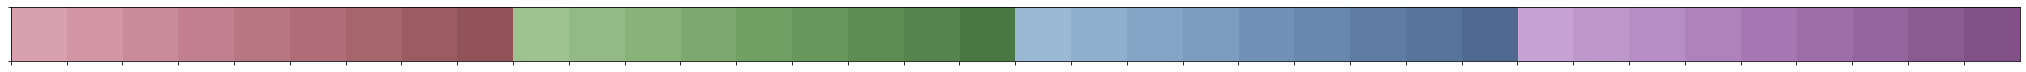

In [38]:
colors = [
    *sns.color_palette("ch:1.0,-.1,light=.7,dark=.4", 9),
    *sns.color_palette("ch:2.0,-.1,light=.7,dark=.4", 9),
    *sns.color_palette("ch:2.9,-.1,light=.7,dark=.4", 9),
    *sns.color_palette("ch:0.5,-.1,light=.7,dark=.4", 9),
]

sns.palplot(colors)

z-score distributions 0 40006 1.1114395061602382
z-score distributions 1 40006 1.4763279945906027
z-score distributions 2 40007 1.7591831651434455
z-score distributions 3 40007 1.243852778026309
z-score distributions 4 40007 1.385331926196401
z-score distributions 5 40007 1.472675581978047
z-score distributions 6 40005 1.4785170956334275
z-score distributions 7 40003 1.5713015400403163
z-score distributions 8 40008 1.4496348600104356
z-score distributions 9 40007 1.147943307142751
z-score distributions 10 40007 1.5175157314445493
z-score distributions 11 40007 1.754439335403253
z-score distributions 12 40004 1.375982155015015
z-score distributions 13 40005 1.4221482681561568
z-score distributions 14 40008 1.4698480453681366
z-score distributions 15 40006 1.645569060416434
z-score distributions 16 40007 1.726569815273355
z-score distributions 17 40009 1.5888784506684872
z-score distributions 18 40006 1.2112499832713206
z-score distributions 19 40008 1.4710685924950613
z-score distributi

(<Figure size 770.4x451.44 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12c083978>)

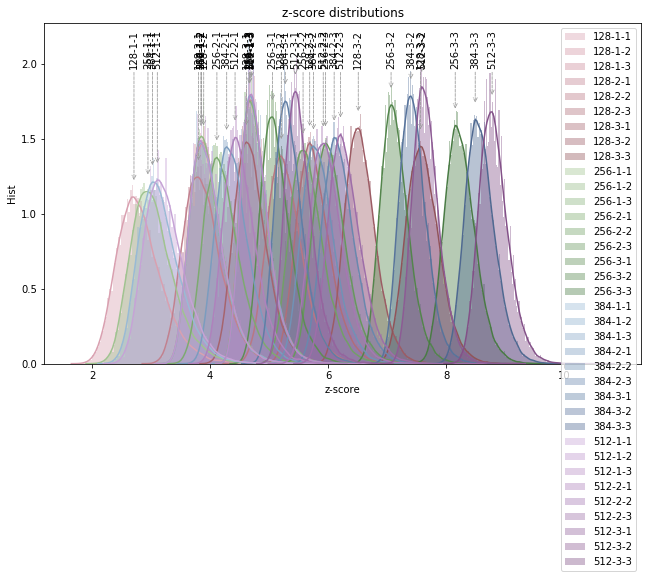

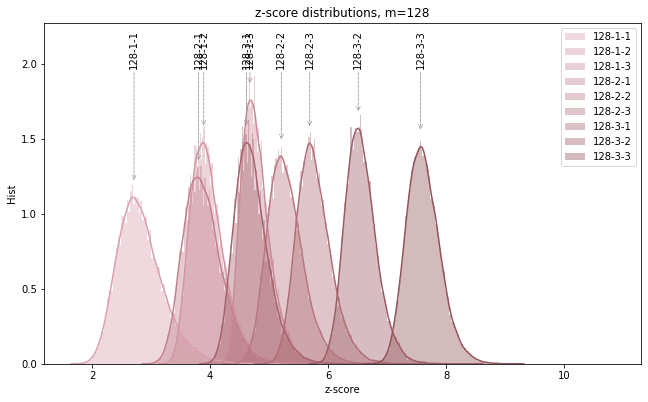

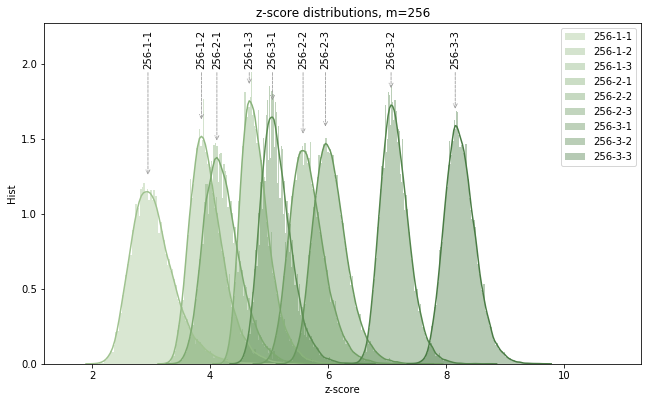

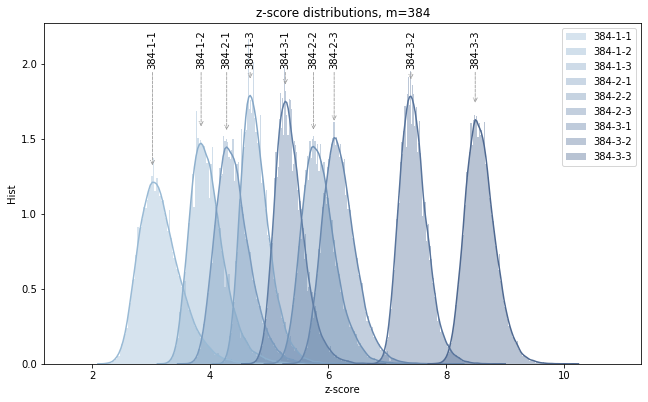

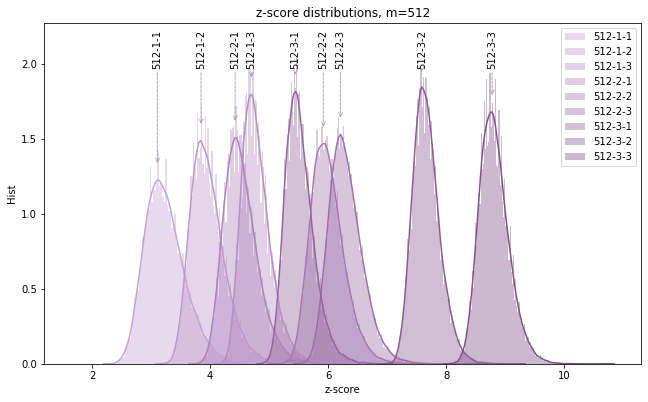

In [83]:
# z-score dist plot
a4_dims = (10.7, 6.27)  #None #(2*11.7, 8.27)
ylim = (0.0, 2.2740367425079864)
xlim = (1.1900278616886606, 11.30353802905374)


def distplots(cregions, colors, desc, fname, xlim=None, ylim=None):
    fig, ax = pyplot.subplots(figsize=a4_dims)
    
    for i in range(len(cregions)):
        zs = [abs(x) for x in cregions[i][1][0][4]]
        lbl = '-'.join([str(x) for x in cregions[i][0]])
        
        r = sns.distplot(a=zs, ax=ax, hist=True, norm_hist=False, bins='auto', label=lbl, kde=True, color=colors[i])
        lx = r.lines[-1].get_xdata()
        ly = r.lines[-1].get_ydata()
        maxi = np.argmax(ly)
        
        ax.annotate(lbl, (lx[maxi], ly[maxi] + 0.1), xytext=(lx[maxi], 2.1),
                    rotation=90, ha='center', va='center', 
                    arrowprops={'arrowstyle':'->', 'connectionstyle':'arc3',
                                "linestyle":"--", "linewidth":0.8, "color":'0.6'})
        print(desc, i, len(zs), ly[maxi])
    
    plt.legend(loc='upper right')
    plt.title(desc if desc else 'z-score distributions')
    ax.set_xlabel("z-score")  
    ax.set_ylabel("Hist")
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    
    plt.savefig(fname, bbox_inches='tight', dpi=400)
    #plt.savefig(os.path.splitext(fname)[0] + '.pdf', bbox_inches='tight', dpi=400)
    return fig, ax

fig, ax = distplots(cregions, colors, 'z-score distributions', 'zscore-dists.png', xlim, ylim)
# print('ylim', ax.get_ylim())
# print('xlim', ax.get_xlim())

distplots(cregions[0*9:1*9], colors[0*9:1*9], 'z-score distributions, m=128', 'zscore-dists-128.png', xlim, ylim)
distplots(cregions[1*9:2*9], colors[1*9:2*9], 'z-score distributions, m=256', 'zscore-dists-256.png', xlim, ylim)
distplots(cregions[2*9:3*9], colors[2*9:3*9], 'z-score distributions, m=384', 'zscore-dists-384.png', xlim, ylim)
distplots(cregions[3*9:4*9], colors[3*9:4*9], 'z-score distributions, m=512', 'zscore-dists-512.png', xlim, ylim)

In [ ]:
a4_dims = (2*11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)
zs = data_filt[1]['zscores']

for  i in range(5):
    zs = [(x) for x in data_filt[i]['zscores']]
    print(len(zs))
    sns.distplot(a=zs, ax=ax, hist=True, norm_hist=False, bins='auto')

# pvalues
 - pvalue = probability (in the null hypothesis distribution) to be observed as a value equal to or more extreme than the value observed
 
## computation 
 - Derive CDF -> find 0 regions = extremes
 - Integrate from 0 regions towards region of increasing integral value. 
 - Once sum of all integrations is alpha, stop. Integrated area is a critical region
 - Computation for x: integrate until the first integral boundary hits x. pvalue = sum of integrals
 - Tabulation: for each desired pvalue compute boundaries (4 values) where critical region starts. 
 - pvalue(x): need to do the integration OR function table (\forall zscores: P(zscore) > 0).
 - In our case 4 extremes, integrate: 
   - -\inf towards 0
   - +\inf towards 0
   - 0 towards +\inf
   - 0 towards -\inf
   - 10000 samples, pvalue = 0 -> 1/10000. 
 - absolutize -> we have a new distribution -> 2x more datapoints, 2 tails.  
  

In [10]:
np.arange(-1, 1, 1/20.)

array([-1.0000000e+00, -9.5000000e-01, -9.0000000e-01, -8.5000000e-01,
       -8.0000000e-01, -7.5000000e-01, -7.0000000e-01, -6.5000000e-01,
       -6.0000000e-01, -5.5000000e-01, -5.0000000e-01, -4.5000000e-01,
       -4.0000000e-01, -3.5000000e-01, -3.0000000e-01, -2.5000000e-01,
       -2.0000000e-01, -1.5000000e-01, -1.0000000e-01, -5.0000000e-02,
        8.8817842e-16,  5.0000000e-02,  1.0000000e-01,  1.5000000e-01,
        2.0000000e-01,  2.5000000e-01,  3.0000000e-01,  3.5000000e-01,
        4.0000000e-01,  4.5000000e-01,  5.0000000e-01,  5.5000000e-01,
        6.0000000e-01,  6.5000000e-01,  7.0000000e-01,  7.5000000e-01,
        8.0000000e-01,  8.5000000e-01,  9.0000000e-01,  9.5000000e-01])

In [11]:
counter = [0] * 8
MAXV = 2

def inc(counter):
    global MAXV
    ln = len(counter) - 1
    while ln >= 0:
        counter[ln] = (counter[ln] + 1) % MAXV
        if (counter[ln] != 0):
            return(counter)
        ln-=1
    raise ValueError('Overflow')

    
def dec(counter):
    global MAXV
    ln = len(counter) - 1
    while ln >= 0:
        counter[ln] = (counter[ln] - 1) % MAXV
        if (counter[ln] != MAXV-1):
            return counter
        ln-=1
    raise ValueError('Underflow')
    
    
for i in range(20):
    print(inc(counter))
print('-'*80)
for i in range(20):
    print(dec(counter))

[0, 0, 0, 0, 0, 0, 0, 1]
[0, 0, 0, 0, 0, 0, 1, 0]
[0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 1, 0, 1]
[0, 0, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 1, 0, 1, 0]
[0, 0, 0, 0, 1, 0, 1, 1]
[0, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 0, 0, 1, 1, 0, 1]
[0, 0, 0, 0, 1, 1, 1, 0]
[0, 0, 0, 0, 1, 1, 1, 1]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 1, 0]
[0, 0, 0, 1, 0, 0, 1, 1]
[0, 0, 0, 1, 0, 1, 0, 0]
--------------------------------------------------------------------------------
[0, 0, 0, 1, 0, 0, 1, 1]
[0, 0, 0, 1, 0, 0, 1, 0]
[0, 0, 0, 1, 0, 0, 0, 1]
[0, 0, 0, 1, 0, 0, 0, 0]
[0, 0, 0, 0, 1, 1, 1, 1]
[0, 0, 0, 0, 1, 1, 1, 0]
[0, 0, 0, 0, 1, 1, 0, 1]
[0, 0, 0, 0, 1, 1, 0, 0]
[0, 0, 0, 0, 1, 0, 1, 1]
[0, 0, 0, 0, 1, 0, 1, 0]
[0, 0, 0, 0, 1, 0, 0, 1]
[0, 0, 0, 0, 1, 0, 0, 0]
[0, 0, 0, 0, 0, 1, 1, 1]
[0, 0, 0, 0, 0, 1, 1, 0]
[0, 0, 0, 0, 0, 1, 0, 1]
[0, 0, 0, 0, 0, 1, 0, 0]
[0, 0, 0, 0, 0, 0, 

In [12]:
from booltest import common


In [13]:
common.generate_seed(2)

b'c2bf37890011dfed'

In [14]:
import os
import time
tmp_files = os.scandir('/tmp')
for i in tmp_files:
    print(i)
    time.sleep(10)

<DirEntry 'com.apple.launchd.RxJEu0LeJ5'>
<DirEntry 'dumps'>
<DirEntry 'powerlog'>
<DirEntry 'com.apple.launchd.nOl6PZPwzO'>
<DirEntry 'com.adobe.reader.rna.0.1f5.DC'>
<DirEntry 'com.apple.launchd.w3Z9dzVsCy'>
<DirEntry 'com.adobe.reader.rna.225.1f5'>


In [15]:
3*3*3*10000*3


810000